# Installing python modules used later on

In [1]:
#Uncomment if training on google colab!

!pip install pytorch_msssim
!pip install torchinfo

# Mount Google Drive

In [2]:
#Uncomment if training on google colab!

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Importing relevant things

In [26]:
import torch
from torchvision import models
from PIL import Image
from torchinfo import summary
from itertools import combinations
import random
import numpy as np
from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset, Dataset
import os
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torch.nn.functional as F
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from pytorch_msssim import SSIM
import random
from torchvision.models import EfficientNet_V2_S_Weights

# Config params

In [27]:
class Config:
    # for local
    # datasets_path = f"../Dataset/splitted_cifar10_dataset.npz"
    # weights_path = f"../weights"

    drive_path = "/content/drive/MyDrive"
    datasets_path = f"{drive_path}/splitted_cifar10_dataset.npz"
    weights_path = f"{drive_path}/weights"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sigma = 0.1
    num_nodes = 11

    learning_rate = 1e-4
    weight_decay = 1e-4
    grad_clip = 0.7

    batch_size = 20
    ucc_limit = 4
    rcc_limit = 10
    bag_size = 24
    num_classes = 10

    train_steps = 50000
    test_steps = 1000
    val_steps = 100
    debug_steps = 1000
    saver_steps = 2000


config = Config()

# Loading the dataset

In [28]:
splitted_dataset = np.load(config.datasets_path)

x_train = splitted_dataset['x_train']
print(f"x_train shape :{x_train.shape}")

y_train = splitted_dataset['y_train']
print(f"y_train shape :{y_train.shape}")

x_val = splitted_dataset['x_val']
print(f"x_val shape :{x_val.shape}")

y_val = splitted_dataset['y_val']
print(f"y_val shape :{y_val.shape}")

x_test = splitted_dataset['x_test']
print(f"x_test shape :{x_test.shape}")

y_test = splitted_dataset['y_test']
print(f"y_test shape: {y_test.shape}")


x_train shape :(40000, 32, 32, 3)
y_train shape :(40000, 1)
x_val shape :(10000, 32, 32, 3)
y_val shape :(10000, 1)
x_test shape :(10000, 32, 32, 3)
y_test shape: (10000, 1)


# Custom Dataloader

This dataloader moves data directly to the device when yielding data

In [29]:
'''
Wrapper on top of dataloader to move tensors to device
'''
class DeviceDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True):
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __iter__(self):
        for batch in super().__iter__():
            yield self._move_to_device(batch)

    def _move_to_device(self, batch):
        if isinstance(batch, torch.Tensor):
            return batch.to(self.device)
        elif isinstance(batch, (list, tuple)):
            return [self._move_to_device(item) for item in batch]
        elif isinstance(batch, dict):
            return {key: self._move_to_device(value) for key, value in batch.items()}
        else:
            return batch


# Defining Dataset

In [30]:
class CIFARDataset(Dataset):
    def __init__(self, x, y, num_iter, train_mode):
        self.x = x
        self.y = y
        self.num_iter = num_iter
        self.train_mode = train_mode

        self.num_classes = config.num_classes

        # for each class get all the indexes of images
        self.class_label_to_img_idxs = self.get_class_label_to_img_idxs_dict()

        # pick the augmentation based on the mode
        if self.train_mode:
            self.transforms = [
                # normal
                transforms.Compose([
                    transforms.ToTensor()
                ]),
                # random horizontal flips
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
                ]),
                # random rotations
                transforms.Compose([
                    transforms.RandomRotation(3),
                    transforms.ToTensor()
                ]),
                # random rotations & flips
                transforms.Compose([
                    transforms.RandomRotation(3),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
                ])
            ]
        else:
            self.transforms = [
                transforms.Compose([
                    transforms.ToTensor(),
                ])
            ]

    def __len__(self):
        return self.num_iter * config.batch_size

    def get_img_from_idx(self, index):
        img = self.x[index]
        img = Image.fromarray(img)
        random_transform = random.choice(self.transforms)
        return random_transform(img)

    def get_label_from_idx(self, index):
        return self.y[index][0]

    def get_class_label_to_img_idxs_dict(self):
        class_label_to_img_idxs_dict = dict()
        for label in range(self.num_classes):
            img_idxs = np.where(self.y == label)[0]
            class_label_to_img_idxs_dict[label] = img_idxs

        return class_label_to_img_idxs_dict

    def __getitem__(self, index):
        label = index % self.num_classes
        label_img_idxs = self.class_label_to_img_idxs[label]
        random_idx = random.choice(label_img_idxs)
        return self.get_img_from_idx(random_idx), self.get_label_from_idx(random_idx)


In [31]:
class UCCDataset(Dataset):
    def __init__(self, x, y, num_iter, train_mode):
        self.x = x
        self.y = y
        self.num_iter = num_iter
        self.train_mode = train_mode

        self.bag_size = config.bag_size
        self.num_classes = config.num_classes
        self.ucc_limit = config.ucc_limit

        # pick the augmentation based on the mode
        if self.train_mode:
            self.transforms = [
                # normal
                transforms.Compose([
                    transforms.ToTensor()
                ]),
                # random horizontal flips
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
                ]),
                # random rotations
                transforms.Compose([
                    transforms.RandomRotation(3),
                    transforms.ToTensor()
                ]),
                # random rotations & flips
                transforms.Compose([
                    transforms.RandomRotation(3),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
                ])
            ]
        else:
            self.transforms = [
                transforms.Compose([
                    transforms.ToTensor(),
                ])
            ]

        # for each class get all the indexes of images
        self.class_label_to_img_idxs = self.get_class_label_to_img_idxs_dict()

        # for each ucc class from (1->4) get all the unique combinations possible
        self.ucc_to_all_combos = self.get_ucc_to_all_combinations_dict()

    def __len__(self):
        return self.num_iter * config.batch_size

    def get_class_label_to_img_idxs_dict(self):
        class_label_to_img_idxs_dict = dict()
        for label_value in range(self.num_classes):
            label_key = f"class{label_value}"

            img_idxs = np.where(self.y == label_value)[0]
            class_label_to_img_idxs_dict[label_key] = img_idxs

        return class_label_to_img_idxs_dict

    def get_ucc_to_all_combinations_dict(self):
        class_labels = np.arange(self.num_classes)
        ucc_to_all_combos_dict = dict()

        for ucc in range(self.ucc_limit):  # go from 1->4
            ucc_key = f"ucc{ucc}"

            ucc_bag_labels = list()
            for unique_ucc_combo in combinations(class_labels, ucc+1): #plus 1 here
                ucc_bag_labels.append(np.array(unique_ucc_combo))

            ucc_to_all_combos_dict[ucc_key] = np.array(ucc_bag_labels)

        return ucc_to_all_combos_dict

    def __getitem__(self, index):
        ucc_label = index % self.ucc_limit
        ucc_combo_with_bag_counts = self.get_random_ucc_combo_and_its_bag_counts(ucc_label)

        selected_idxs = []
        for label, freq in ucc_combo_with_bag_counts:
            label_key = f"class{label}"
            label_img_idxs = self.class_label_to_img_idxs[label_key]
            selected_idxs.extend(list(label_img_idxs[np.random.randint(0, len(label_img_idxs), size=freq)]))

        imgs = self.get_imgs_from_idxs(selected_idxs)
        return imgs, ucc_label

    def get_random_ucc_combo_and_its_bag_counts(self, ucc_label):
        class_key = f"ucc{ucc_label}"

        # Get unique combination of cifar10 labels for ucc label
        ucc_bag_labels_list = self.ucc_to_all_combos[class_key]
        idx = np.random.randint(0, ucc_bag_labels_list.shape[0])
        ucc_labels = ucc_bag_labels_list[idx, :]

        # Get even distribution of instances per label with max difference of 1
        N = ucc_labels.shape[0]
        n_instances = self.bag_size // N

        counts = np.repeat(n_instances, N)

        res = []
        for label, freq in zip(ucc_labels, counts):
            res.append((label, freq))
        return res

    def get_imgs_from_idxs(self, idxs):
        imgs = self.x[idxs]
        res = []
        for i in range(len(imgs)):
            img = Image.fromarray(imgs[i])
            random_transform = random.choice(self.transforms)
            res.append(random_transform(img).unsqueeze(0))
        res = torch.concatenate(res, dim=0)
        return res


## Creating the Dataloader

In [32]:
class Dataloaders:
    def __init__(self):
        data = np.load(config.datasets_path)
        x_train, y_train = data["x_train"], data["y_train"]
        x_val, y_val = data["x_val"], data["y_val"]
        x_test, y_test = data["x_test"], data["y_test"]

        #construct ucc datasets
        self.ucc_train_dataset = UCCDataset(x_train, y_train, config.train_steps, True)
        self.ucc_val_dataset = UCCDataset(x_val, y_val, config.val_steps, False)
        self.ucc_test_dataset = UCCDataset(x_test, y_test, config.test_steps, False)

        #construct cifar datasets
        self.cifar_train_dataset = CIFARDataset(x_train, y_train, config.train_steps, True)
        self.cifar_val_dataset = CIFARDataset(x_val, y_val, config.val_steps, False)
        self.cifar_test_dataset = CIFARDataset(x_test, y_test, config.test_steps, False)

        #delete the extra unnecessary space
        del data
        del x_train
        del x_test
        del x_val
        del y_train
        del y_test
        del y_val

    def get_ucc_dataloaders(self):
        train_loader = DeviceDataLoader(self.ucc_train_dataset, config.batch_size)
        val_loader = DeviceDataLoader(self.ucc_val_dataset, config.batch_size)
        test_loader = DeviceDataLoader(self.ucc_test_dataset, config.batch_size)
        return train_loader, val_loader, test_loader

    def get_cifar_dataloaders(self):
        train_loader = DeviceDataLoader(self.cifar_train_dataset, config.batch_size)
        val_loader = DeviceDataLoader(self.cifar_val_dataset, config.batch_size)
        test_loader = DeviceDataLoader(self.cifar_test_dataset, config.batch_size)
        return train_loader, val_loader, test_loader


In [33]:
dataloaders = Dataloaders()

# Checking how one bag looks like

Checking out train


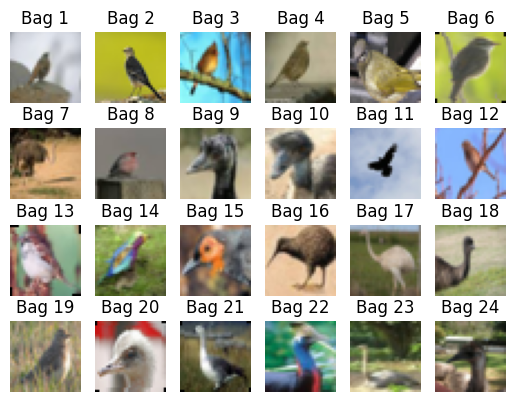

Checking out val


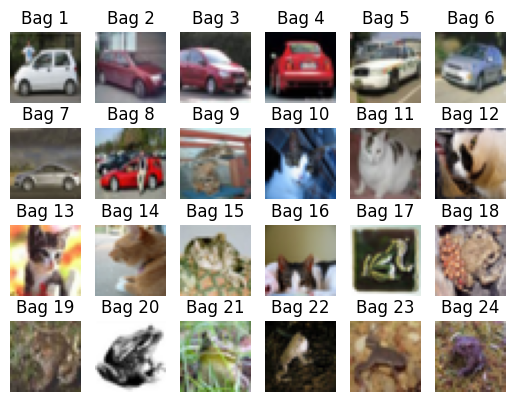

Checking out test


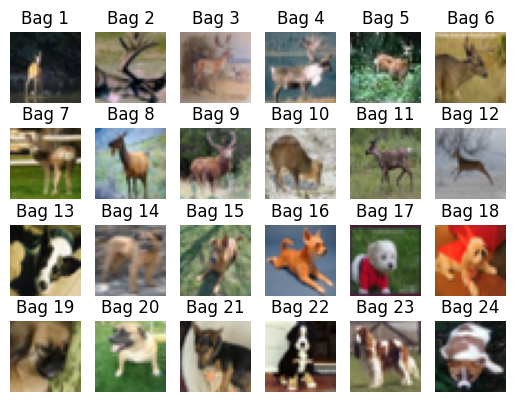

In [34]:
#printing the images in a bag
import matplotlib.pyplot as plt

tensor_to_img_transform = transforms.ToPILImage()
ucc_train_loader, ucc_val_loader, ucc_test_loader = dataloaders.get_ucc_dataloaders()
ucc_dataloaders = [ucc_train_loader, ucc_val_loader, ucc_test_loader]
names = ["train", "val", "test"]

for ucc_dataloader, name in zip(ucc_dataloaders, names):
    print(f"Checking out {name}")
    for data in ucc_dataloader:
        batches, _ = data
        for bag in batches:
            for image_index, image in enumerate(bag):
                image = tensor_to_img_transform(image)
                plt.subplot(4, 6, image_index + 1)  # Assuming 24 images per bag
                plt.imshow(image)  # Display the image
                plt.title(f"Bag {image_index + 1}")  # Set the title
                plt.axis('off')  # Turn off axis labels
            plt.show()
            break
        break
plt.show()



## SSIM Loss definition

In [35]:
class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()
        self.ssim = SSIM()

    def forward(self, x, y):
        # Calculate SSIM
        ssim_value = self.ssim(x, y)
        # Subtract SSIM from 1
        loss = 1 - ssim_value
        return loss

# Model architectures

## Autoencoder

In [44]:
class ResidualZeroPaddingBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            first_block=False,
            down_sample=False,
            up_sample=False,
    ):
        super(ResidualZeroPaddingBlock, self).__init__()
        self.first_block = first_block
        self.down_sample = down_sample
        self.up_sample = up_sample

        if self.up_sample:
            self.upsampling = nn.Upsample(scale_factor=2, mode="nearest")

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            stride=2 if self.down_sample else 1,
        )
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.skip_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=2 if self.down_sample else 1,
        )

        # Initialize the weights and biases
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0.1)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0.1)
        nn.init.xavier_uniform_(self.skip_conv.weight)

    def forward(self, x):
        if self.first_block:
            x = nn.LeakyReLU()(x)
            if self.up_sample:
                x = self.upsampling(x)
            out = nn.LeakyReLU()(self.conv1(x))
            out = self.conv2(out)
            if x.shape != out.shape:
                x = self.skip_conv(x)
        else:
            out = nn.LeakyReLU()(self.conv1(x))
            out = nn.LeakyReLU()(self.conv2(out))
        return x + out


class WideResidualBlocks(nn.Module):
    def __init__(
            self, in_channels, out_channels, n, down_sample=False, up_sample=False
    ):
        super(WideResidualBlocks, self).__init__()
        self.blocks = nn.Sequential(
            *[
                ResidualZeroPaddingBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    first_block=(i == 0),
                    down_sample=down_sample,
                    up_sample=up_sample,
                )
                for i in range(n)
            ]
        )

    def forward(self, x):
        return self.blocks(x)


class Reshape(nn.Module):
    def __init__(self, *target_shape):
        super(Reshape, self).__init__()
        self.target_shape = target_shape

    def forward(self, x):
        return x.view(x.size(0), *self.target_shape)

class PretrainedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        pretrained_model = models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1).to(config.device)
        self.pretrained_encoder = nn.Sequential(*list(pretrained_model.children())[:-1]).to(config.device)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(128, 10)
        ).to(config.device)

        self.decoder = nn.Sequential(
            nn.Linear(10, 512),
            Reshape(*[512, 1, 1]),
            WideResidualBlocks(
                512,
                256,
                1,
                up_sample=True,
            ),
            WideResidualBlocks(
                256,
                128,
                1,
                up_sample=True,
            ),
            WideResidualBlocks(
                128,
                64,
                1,
                up_sample=True,
            ),
            WideResidualBlocks(
                64,
                32,
                1,
                up_sample=True,
            ),
            WideResidualBlocks(
                32,
                16,
                1,
                up_sample=True,
            ),
            WideResidualBlocks(
                16,
                8,
                1
            ),
            nn.Conv2d(
                8,
                3,
                kernel_size=3,
                padding=1,
            )
        ).to(config.device)

        # Freeze all the parameters
        for param in self.pretrained_encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        pretrained_features = self.pretrained_encoder(x)
        features = self.encoder(pretrained_features).to(config.device)
        reconstruction = self.decoder(features)
        return features, reconstruction


## Kernel Density Estimator

In [45]:
class KDE(nn.Module):
    def __init__(self, device=config.device, num_nodes=config.num_nodes, sigma=config.sigma):
        super(KDE, self).__init__()
        self.num_nodes = num_nodes
        self.sigma = sigma
        self.device = device
        print("KDE Layer initialized")

    def forward(self, data):
        batch_size, num_instances, num_features = data.shape

        # Create sample points
        k_sample_points = (
            torch.linspace(0, 1, steps=config.num_nodes)
            .repeat(batch_size, num_instances, 1)
            .to(self.device)
        )

        # Calculate constants
        k_alpha = 1 / np.sqrt(2 * np.pi * config.sigma ** 2)
        k_beta = -1 / (2 * config.sigma ** 2)

        # Iterate over features and calculate kernel density estimation for each feature
        out_list = []
        for i in range(num_features):
            one_feature = data[:, :, i: i + 1].repeat(1, 1, config.num_nodes)
            k_diff_2 = (k_sample_points - one_feature) ** 2
            k_result = k_alpha * torch.exp(k_beta * k_diff_2)
            k_out_unnormalized = k_result.sum(dim=1)
            k_norm_coeff = k_out_unnormalized.sum(dim=1).view(-1, 1)
            k_out = k_out_unnormalized / k_norm_coeff.repeat(
                1, k_out_unnormalized.size(1)
            )
            out_list.append(k_out)

        # Concatenate the results
        concat_out = torch.cat(out_list, dim=-1).to(self.device)
        return concat_out


## UCC Prediction model

In [46]:
class UCCModel(nn.Module):
    def __init__(self, device=config.device, autoencoder_model=None, ucc_limit=config.ucc_limit):
        super().__init__()
        if autoencoder_model:
            self.autoencoder = autoencoder_model
        else:
            self.autoencoder = PretrainedAutoencoder()

        self.kde = KDE(device)
        self.ucc_predictor = nn.Sequential(
            nn.Linear(110, 256),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(256, 64, dtype=torch.float32),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(64, ucc_limit, dtype=torch.float32)
        )

        print("UCC model initialized")

    def forward(self, batch):
        # Input size: [batch, bag, 3, 32, 32]
        # output size: [batch, 4] (ucc_logits), [batch * bag,3,32,32] ( decoded images)

        # Stage 1. pass through autoencoder
        batch_size, bag_size, num_channels, height, width = batch.size()
        batches_of_image_bags = batch.view(batch_size * bag_size, num_channels, height, width).to(torch.float32)
        features, decoded = self.autoencoder(
            batches_of_image_bags
        )  # we are feeding in Batch*bag images of shape (3,32,32)

        # Stage 2. use the autoencoder latent features to pass through the ucc predictor
        # features shape is now (Batch* Bag, 128) -> (Batch, Bag, 128)
        features = features.view(batch_size, bag_size, features.size(1))

        # Stage 3. pass through kde to get output shape (Batch, 128*11)
        kde_prob_distributions = self.kde(features)

        # Stage 4. pass through the ucc_predictor stack to get 4 logits in the end
        ucc_logits = self.ucc_predictor(kde_prob_distributions)

        return ucc_logits, decoded  # (Batch , 4), (Batch * Bag, 3,32,32)

    def get_encoder_features(self, batch):
        batch_size, bag_size, num_channels, height, width = batch.size()
        batches_of_image_bags = batch.view(batch_size * bag_size, num_channels, height, width).to(torch.float32)
        features, _ = self.autoencoder(
            batches_of_image_bags
        )  # we are feeding in Batch*bag images of shape (3,32,32)
        return features

    def get_kde_distributions(self, batch):
        batch_size, bag_size, num_channels, height, width = batch.size()
        batches_of_image_bags = batch.view(batch_size * bag_size, num_channels, height, width).to(torch.float32)
        features, _ = self.autoencoder(
            batches_of_image_bags
        )  # we are feeding in Batch*bag images of shape (3,32,32)
        features = features.view(batch_size, bag_size, features.size(1))

        kde_prob_distributions = self.kde(features)
        return kde_prob_distributions


## UCC model trainable params

In [47]:
ucc = UCCModel(config.device).to(config.device)
summary(ucc, input_size=(config.bag_size, 3, 32, 32), device=config.device, batch_dim=0, col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], verbose=1)

KDE Layer initialized
UCC model initialized
Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
UCCModel                                                          [1, 24, 3, 32, 32]        [1, 4]                    --                        --                        --
├─PretrainedAutoencoder: 1-1                                      [1, 3, 32, 32]            [1, 10]                   --                        --                        --
│    └─Sequential: 2-1                                            [1, 3, 32, 32]            [24, 1280, 1, 1]          --                        --                        --
│    │    └─Sequential: 3-1                                       [1, 3, 32, 32]            [24, 1280, 1, 1]          (20,177,488)              --                        1,485,940,416
│    │    └─AdaptiveAvgPool2d: 3-2                                [1, 128

Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
UCCModel                                                          [1, 24, 3, 32, 32]        [1, 4]                    --                        --                        --
├─PretrainedAutoencoder: 1-1                                      [1, 3, 32, 32]            [1, 10]                   --                        --                        --
│    └─Sequential: 2-1                                            [1, 3, 32, 32]            [24, 1280, 1, 1]          --                        --                        --
│    │    └─Sequential: 3-1                                       [1, 3, 32, 32]            [24, 1280, 1, 1]          (20,177,488)              --                        1,485,940,416
│    │    └─AdaptiveAvgPool2d: 3-2                                [1, 1280, 1, 1]           [24, 1280, 1, 1]         

# EXPERIMENT-1 : UCC Model

This model tries to replicate the paper where we have an autoencoder path and a ucc path.

Similarly experiment-2 will be the improvement model

## Code for plotting the model stats

In [48]:
def plot_ucc_model_stats(
        experiment, epochs,
        ucc_training_losses, ae_training_losses, combined_training_losses,
        ucc_training_accuracy,
        ucc_validation_losses, ae_validation_losses, combined_validation_losses,
        ucc_validation_accuracy
    ):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Plot training losses
    axes[0, 0].plot(epochs, ucc_training_losses, marker="o", color="red", label="UCC Training Loss")
    axes[0, 0].plot(epochs, ae_training_losses, marker="o", color="blue", label="AE Training Loss")
    axes[0, 0].plot(epochs, combined_training_losses, marker="o", color="green", label="Combined Training Loss")
    axes[0, 0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')
    axes[0, 0].legend()  # Display the legend

    # Plot training accuracy
    axes[0, 1].plot(epochs, ucc_training_accuracy, marker="o", color="red", label="UCC Training Accuracy")
    axes[0, 1].set_title(f'{experiment}: Training Accuracy vs Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Training Accuracy')
    axes[0, 1].legend()  # Display the legend

    # Plot validation losses
    axes[1, 0].plot(epochs, ucc_validation_losses, marker="o", color="red", label="UCC Validation Loss")
    axes[1, 0].plot(epochs, ae_validation_losses, marker="o", color="blue", label="AE Validation Loss")
    axes[1, 0].plot(epochs, combined_validation_losses, marker="o", color="green", label="Combined Validation Loss")
    axes[1, 0].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Loss')
    axes[1, 0].legend()  # Display the legend

    # Plot validation accuracy 1,1
    axes[1, 1].plot(epochs, ucc_validation_accuracy, marker="o", color="red", label="UCC Validation Accuracy")
    axes[1, 1].set_title(f'{experiment}: Validation Accuracy vs Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].legend()  # Display the legend

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()

## UCC Trainer class

In [49]:
class UCCTrainer:
    def __init__(self,
                 name, ucc_model,
                 dataloader, save_dir, device=config.device,
                 importances={"ae": 0.5, "ucc": 0.5},
                 use_ssim=False
                 ):
        self.name = name
        self.save_dir = save_dir
        self.device = device

        # importances
        self.ae_importance = importances["ae"]
        self.ucc_importance = importances["ucc"]

        # dataloaders
        self.train_loader, self.val_loader, self.test_loader = dataloader.get_ucc_dataloaders()
        self.cifar_train_loader, self.cifar_val_loader, self.cifar_test_loader = dataloader.get_cifar_dataloaders()

        # create the directory if it doesn't exist!
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(os.path.join(self.save_dir, self.name), exist_ok=True)

        self.ucc_model = ucc_model

        # Adam optimizer(s)
        self.ucc_optimizer = optim.Adam(self.ucc_model.parameters(), lr=config.learning_rate,
                                        weight_decay=config.weight_decay)

        # Loss criterion(s)
        self.ae_loss_criterion = SSIMLoss() if use_ssim else nn.MSELoss()
        self.ucc_loss_criterion = nn.CrossEntropyLoss()

        # Transforms
        self.tensor_to_img_transform = transforms.ToPILImage()

        # Values which can change based on loaded checkpoint
        self.steps = []
        self.training_ae_losses = []
        self.training_ucc_losses = []
        self.training_losses = []
        self.training_ucc_accuracies = []

        self.val_ae_losses = []
        self.val_ucc_losses = []
        self.val_losses = []
        self.val_ucc_accuracies = []

        self.train_correct_predictions = 0
        self.train_total_batches = 0

        # Debug saver lists (i.e. capture these stats for every debug_steps)
        self.debug_ae_losses = []
        self.debug_ucc_losses = []
        self.debug_total_losses = []

    # main train code
    def train(self,
              resume_steps=None,
              load_from_checkpoint=False,
              saver_steps=config.saver_steps):
        torch.cuda.empty_cache()

        # initialize the params from the saved checkpoint
        self.init_params_from_checkpoint_hook(load_from_checkpoint, resume_steps)

        # set up scheduler
        self.init_scheduler_hook()

        # Custom progress bar for each epoch with color
        batch_progress_bar = tqdm(
            total=len(self.train_loader),
            desc=f"Steps",
            position=1,
            leave=False,
            dynamic_ncols=True,
            ncols=100,
            colour='green'
        )

        # set all models to train mode
        self.ucc_model.train()

        # iterate over each batch
        for step, data in enumerate(self.train_loader):
            # zero grad
            self.ucc_optimizer.zero_grad()

            images, ucc_labels = data

            # forward propogate through the combined model
            ucc_logits, decoded = self.ucc_model(images)

            # calculate losses from both models for a batch of bags
            ae_loss = self.calculate_autoencoder_loss(images, decoded)
            ucc_loss, batch_ucc_accuracy = self.calculate_ucc_loss_and_acc(ucc_logits, ucc_labels, True)

            # calculate combined loss
            step_loss = (self.ae_importance * ae_loss) + (self.ucc_importance * ucc_loss)

            # do loss backward for all losses
            step_loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(self.ucc_model.parameters(), max_norm=config.grad_clip)

            # do optimizer step
            self.ucc_optimizer.step()

            # scheduler update (remove if it doesnt work!)
            self.ucc_scheduler.step()

            # add to epoch batch_loss
            self.debug_ae_losses.append(ae_loss.item())
            self.debug_ucc_losses.append(ucc_loss.item())
            self.debug_total_losses.append(step_loss.item())

            # Update the epoch progress bar (overwrite in place)
            batch_stats = {
                "batch_loss": step_loss.item(),
                "batch_ae_loss": ae_loss.item(),
                "batch_ucc_loss": ucc_loss.item(),
                "batch_ucc_acc": batch_ucc_accuracy
            }

            batch_progress_bar.set_postfix(batch_stats)
            batch_progress_bar.update(1)

            # Compute the average stats for every config.debug_steps steps
            if (step + 1) % config.debug_steps == 0:
                # calculate average epoch train statistics
                avg_train_stats = self.calculate_avg_train_stats_hook()

                # calculate validation statistics
                avg_val_stats = self.validation_hook()

                # Store running history
                self.print_stats_and_store_running_history_hook(step + 1, avg_train_stats, avg_val_stats)

                # Clear the list
                self.debug_ae_losses = []
                self.debug_ucc_losses = []
                self.debug_total_losses = []

            # Save model checkpoint periodically
            if (step + 1) % saver_steps == 0:
                print(f"Going to save model {self.name} @ Step:{step + 1}")
                self.save_model_checkpoint_hook(step + 1)

        # close the epoch progress bar
        batch_progress_bar.close()

        # Return the current state
        return self.get_current_running_history_state_hook()

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_steps):
        if load_from_checkpoint:
            # NOTE: resume_epoch_num can be None here if we want to load from the most recently saved checkpoint!
            checkpoint_path = self.get_model_checkpoint_path(resume_steps)
            checkpoint = torch.load(checkpoint_path)

            # load previous state of models
            self.ucc_model.load_state_dict(checkpoint['ucc_model_state_dict'])

            # load previous state of optimizers
            self.ucc_optimizer.load_state_dict(checkpoint['ucc_optimizer_state_dict'])

            # Things we are keeping track of
            self.steps = checkpoint['steps']

            self.training_losses = checkpoint['training_losses']
            self.training_ae_losses = checkpoint['training_ae_losses']
            self.training_ucc_losses = checkpoint['training_ucc_losses']
            self.training_ucc_accuracies = checkpoint['training_ucc_accuracies']

            self.val_losses = checkpoint['val_losses']
            self.val_ae_losses = checkpoint['val_ae_losses']
            self.val_ucc_losses = checkpoint['val_ucc_losses']
            self.val_ucc_accuracies = checkpoint['val_ucc_accuracies']

            print(f"Model checkpoint for {self.name} is loaded from {checkpoint_path}!")

    def init_scheduler_hook(self):
        self.ucc_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.ucc_optimizer,
            config.learning_rate,
            total_steps=len(self.train_loader)
        )

    def calculate_autoencoder_loss(self, images, decoded):
        # data is of shape (batchsize=2,bag=10,channels=3,height=32,width=32)
        # generally batch size of 16 is good for cifar10 so predicting 20 won't be so bad
        batch_size, bag_size, num_channels, height, width = images.size()
        batches_of_bag_images = images.view(batch_size * bag_size, num_channels, height, width).to(torch.float32)
        ae_loss = self.ae_loss_criterion(decoded, batches_of_bag_images)  # compares (Batch * Bag, 3,32,32)
        return ae_loss

    def calculate_ucc_loss_and_acc(self, ucc_logits, ucc_labels, is_train_mode=True):
        # compute the batch stats right here and save it
        ucc_probs = nn.Softmax(dim=1)(ucc_logits)
        predicted = torch.argmax(ucc_probs, 1)  # adding one so that it can be match properly
        batch_correct_predictions = (predicted == ucc_labels).sum().item()
        batch_size = ucc_labels.size(0)
        batch_ucc_accuracy = batch_correct_predictions / batch_size

        # compute the ucc_loss between [batch, 4], [Batch,] batch size = 2
        ucc_loss = self.ucc_loss_criterion(ucc_logits, ucc_labels)

        # calculate batchwise accuracy/ucc_loss
        if is_train_mode:
            self.train_correct_predictions += batch_correct_predictions
            self.train_total_batches += batch_size
        else:
            self.eval_correct_predictions += batch_correct_predictions
            self.eval_total_batches += batch_size
        return ucc_loss, batch_ucc_accuracy

    def calculate_avg_train_stats_hook(self):
        avg_ae_loss_for_epoch = np.mean(np.array(self.debug_ae_losses))
        avg_ucc_loss_for_epoch = np.mean(np.array(self.debug_ucc_losses))
        avg_training_loss_for_epoch = np.mean(np.array(self.debug_total_losses))
        avg_ucc_training_accuracy = self.train_correct_predictions / self.train_total_batches

        epoch_train_stats = {
            "avg_training_loss": avg_training_loss_for_epoch,
            "avg_ae_loss": avg_ae_loss_for_epoch,
            "avg_ucc_loss": avg_ucc_loss_for_epoch,
            "avg_ucc_training_accuracy": avg_ucc_training_accuracy
        }

        # reset
        self.train_correct_predictions = 0
        self.train_total_batches = 0

        return epoch_train_stats

    def validation_hook(self):
        # class level init
        self.eval_correct_predictions = 0
        self.eval_total_batches = 0

        val_loss = []
        val_ae_loss = []
        val_ucc_loss = []

        with torch.no_grad():
            # set all models to eval mode
            self.ucc_model.eval()

            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_images, val_ucc_labels = val_data

                # forward propogate through the model
                val_ucc_logits, val_decoded = self.ucc_model(val_images)

                # calculate losses from both models for a batch of bags
                val_batch_ae_loss = self.calculate_autoencoder_loss(val_images, val_decoded)
                val_batch_ucc_loss, val_batch_ucc_accuracy = self.calculate_ucc_loss_and_acc(val_ucc_logits,
                                                                                             val_ucc_labels, False)
                # calculate combined loss
                val_batch_loss = (self.ae_importance * val_batch_ae_loss) + (self.ucc_importance * val_batch_ucc_loss)

                # cummulate the losses
                val_ae_loss.append(val_batch_ae_loss.item())
                val_ucc_loss.append(val_batch_ucc_loss.item())
                val_loss.append(val_batch_loss.item())

        # Calculate average validation loss for the epoch
        avg_val_loss = np.mean(np.array(val_loss))
        avg_val_ucc_loss = np.mean(np.array(val_ucc_loss))
        avg_val_ae_loss = np.mean(np.array(val_ae_loss))
        avg_val_ucc_training_accuracy = self.eval_correct_predictions / self.eval_total_batches

        stats = {
            "avg_val_loss": avg_val_loss,
            "avg_val_ae_loss": avg_val_ae_loss,
            "avg_val_ucc_loss": avg_val_ucc_loss,
            "avg_val_ucc_training_accuracy": avg_val_ucc_training_accuracy
        }

        # show some sample predictions
        self.show_sample_reconstructions(self.val_loader)
        return stats

    def print_stats_and_store_running_history_hook(self, curr_step, avg_train_stats, avg_val_stats):
        loss = avg_train_stats["avg_training_loss"]
        ae_loss = avg_train_stats["avg_ae_loss"]
        ucc_loss = avg_train_stats["avg_ucc_loss"]
        ucc_accuracy = avg_train_stats["avg_ucc_training_accuracy"]

        val_loss = avg_val_stats["avg_val_loss"]
        val_ae_loss = avg_val_stats["avg_val_ae_loss"]
        val_ucc_loss = avg_val_stats["avg_val_ucc_loss"]
        val_ucc_accuracy = avg_val_stats["avg_val_ucc_training_accuracy"]

        # store running history
        self.steps.append(curr_step)
        self.training_losses.append(loss)
        self.training_ae_losses.append(ae_loss)
        self.training_ucc_losses.append(ucc_loss)
        self.training_ucc_accuracies.append(ucc_accuracy)

        self.val_losses.append(val_loss)
        self.val_ae_losses.append(val_ae_loss)
        self.val_ucc_losses.append(val_ucc_loss)
        self.val_ucc_accuracies.append(val_ucc_accuracy)

        # print stats
        print(
            f"[TRAIN]:Step: {curr_step} | Loss: {loss} | AE Loss: {ae_loss} | UCC Loss: {ucc_loss} | UCC Acc: {ucc_accuracy}"
        )
        print(
            f"[VAL]:Step: {curr_step} | Val Loss: {val_loss} | Val AE Loss: {val_ae_loss} | Val UCC Loss: {val_ucc_loss} | Val UCC Acc: {val_ucc_accuracy}"
        )
        print()
        print("-" * 60)

    def get_current_running_history_state_hook(self):
        return self.steps, \
            self.training_ae_losses, self.training_ucc_losses, self.training_losses, self.training_ucc_accuracies, \
            self.val_ae_losses, self.val_ucc_losses, self.val_losses, self.val_ucc_accuracies

    def save_model_checkpoint_hook(self, step):
        # set it to train mode to save the weights (but doesn't matter apparently!)
        self.ucc_model.train()

        # create the directory if it doesn't exist
        model_save_directory = os.path.join(self.save_dir, self.name)
        os.makedirs(model_save_directory, exist_ok=True)

        # Checkpoint the model at the end of each epoch
        checkpoint_path = os.path.join(model_save_directory, f'model_step_{step + 1}.pt')
        torch.save(
            {
                'ucc_model_state_dict': self.ucc_model.state_dict(),
                'ucc_optimizer_state_dict': self.ucc_optimizer.state_dict(),
                'steps': self.steps,
                'training_losses': self.training_losses,
                'training_ae_losses': self.training_ae_losses,
                'training_ucc_losses': self.training_ucc_losses,
                'training_ucc_accuracies': self.training_ucc_accuracies,
                'val_losses': self.val_losses,
                'val_ae_losses': self.val_ae_losses,
                'val_ucc_losses': self.val_ucc_losses,
                'val_ucc_accuracies': self.val_ucc_accuracies,
            },
            checkpoint_path
        )
        print(f"Saved the model checkpoint for experiment {self.name} for step {step + 1}")

    def test_model(self):
        # class level init
        self.eval_correct_predictions = 0
        self.eval_total_batches = 0

        test_loss = []
        test_ae_loss = []
        test_ucc_loss = []

        with torch.no_grad():
            # set all models to eval mode
            self.ucc_model.eval()

            for test_batch_idx, test_data in enumerate(self.test_loader):
                test_images, test_ucc_labels = test_data

                # forward propogate through the model
                test_ucc_logits, test_decoded = self.ucc_model(test_images)

                # calculate losses from both models for a batch of bags
                test_batch_ae_loss = self.calculate_autoencoder_loss(test_images, test_decoded)
                test_batch_ucc_loss, test_batch_ucc_accuracy = self.calculate_ucc_loss_and_acc(test_ucc_logits,
                                                                                               test_ucc_labels,
                                                                                               False)

                # calculate combined loss
                test_batch_loss = (self.ae_importance * test_batch_ae_loss) + (self.ucc_importance * test_batch_ucc_loss)

                # cummulate the losses
                test_ae_loss.append(test_batch_ae_loss.item())
                test_ucc_loss.append(test_batch_ucc_loss.item())
                test_loss.append(test_batch_loss.item())

        # Calculate average validation loss for the epoch
        avg_test_loss = np.mean(np.array(test_loss))
        avg_test_ucc_loss = np.mean(np.array(test_ucc_loss))
        avg_test_ae_loss = np.mean(np.array(test_ae_loss))
        avg_test_ucc_training_accuracy = self.eval_correct_predictions / self.eval_total_batches

        stats = {
            "avg_test_loss": avg_test_loss,
            "avg_test_ae_loss": avg_test_ae_loss,
            "avg_test_ucc_loss": avg_test_ucc_loss,
            "avg_test_ucc_training_accuracy": avg_test_ucc_training_accuracy
        }
        # show some sample predictions
        self.show_sample_reconstructions(self.test_loader)
        return stats

    def show_sample_reconstructions(self, dataloader):
        # Create a subplot grid
        fig, axes = plt.subplots(1, 2, figsize=(3, 3))

        with torch.no_grad():
            # set all models to eval mode
            self.ucc_model.eval()

            for val_data in dataloader:
                val_images, _ = val_data

                # reshape to appropriate size
                batch_size, bag_size, num_channels, height, width = val_images.size()
                bag_val_images = val_images.view(batch_size * bag_size, num_channels, height, width)
                print("Reshaped the original image into bag format")

                # forward propagate through the model
                _, val_reconstructed_images = self.ucc_model(val_images)
                print("Got a sample reconstruction, now trying to reshape in order to show an example")

                # take only one image from the bag
                sample_image = bag_val_images[0]
                predicted_image = val_reconstructed_images[0]

                # get it to cpu
                sample_image = sample_image.to("cpu")
                predicted_image = predicted_image.to("cpu")

                # convert to PIL Image
                sample_image = self.tensor_to_img_transform(sample_image)
                predicted_image = self.tensor_to_img_transform(predicted_image)

                axes[0].imshow(sample_image)
                axes[0].set_title(f"Orig", color='green')
                axes[0].axis('off')

                axes[1].imshow(predicted_image)
                axes[1].set_title(f"Recon", color='red')
                axes[1].axis('off')

                # show only one image
                break

        plt.tight_layout()
        plt.show()

    # find the most recent file and return the path
    def get_model_checkpoint_path(self, step_num=None):
        directory = os.path.join(self.save_dir, self.name)
        if step_num == None:
            # Get a list of all files in the directory
            files = os.listdir(directory)

            # Filter out only the files (exclude directories)
            files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

            # Sort the files by their modification time in descending order (most recent first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

            # Get the name of the most recently added file
            model_file = files[0] if files else None
        else:
            model_file = f"model_step_{step_num}.pt"
        return os.path.join(directory, model_file)

    # Calculate min JS Divergence
    def calculate_js_divergence(self, p, q):
        m = 0.5 * (p + q)
        log_p_over_m = np.log2(p / m)
        log_q_over_m = np.log2(q / m)
        return 0.5 * np.sum(p * log_p_over_m) + 0.5 * np.sum(q * log_q_over_m)

    def get_all_kde_distributions(self):
        self.ucc_model.eval()

        kde_distributions = []
        all_labels = []
        with torch.no_grad():
            for imgs, labels in tqdm(self.cifar_test_loader):
                imgs = imgs.unsqueeze(1).to(config.device)
                kde_dist = self.ucc_model.get_kde_distributions(imgs)
                kde_distributions.append(kde_dist.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        kde_distributions = np.concatenate(kde_distributions)
        all_labels = np.concatenate(all_labels)
        return kde_distributions, all_labels

    def compute_min_js_divergence(self):
        kde_distributions, all_labels = self.get_all_kde_distributions()
        print("Got the KDE distributions for the test dataset")

        # iterate for each class and get only those embeddings
        distribution_of_all_label_classes = []
        for i in range(config.num_classes):
            idxs = np.where(all_labels == i)
            kde_distribution_i = kde_distributions[idxs]
            kde_distribution_i = np.mean(kde_distribution_i, axis=0)
            distribution_of_all_label_classes.append(kde_distribution_i)
        distribution_of_all_label_classes = np.array(distribution_of_all_label_classes)
        print("Got the average kde distribution per label class, now computing min js divergence")

        res = np.zeros((config.num_classes, config.num_classes))
        for i in range(config.num_classes):
            p = np.clip(distribution_of_all_label_classes[i, :], 1e-12, 1)
            # p = distribution_of_all_label_classes[i, :]
            for j in range(i, config.num_classes):
                q = np.clip(distribution_of_all_label_classes[j, :], 1e-12, 1)
                # q = distribution_of_all_label_classes[j, :]

                # fill the upper triangle
                res[i, j] = self.calculate_js_divergence(p, q)

                # fill the lower triangle
                res[j, i] = res[i, j]

        # we are not interested in the identity relation anyway
        np.fill_diagonal(res, np.inf)
        print("Computed all interclass js divergence scores, the entire interclass js divergence is ")
        print(res)
        # Find the minimum value
        min_js_divergence = np.min(res)

        # Find the indices of the minimum value
        min_indices = np.argmin(res)
        min_row, min_col = np.unravel_index(min_indices, res.shape)

        print(f"Min JS Divergence is {min_js_divergence}, between classes {min_row} & {min_col}")
        return min_js_divergence

    # Calculate clustering accuracy
    def get_all_encoder_features(self):
        self.ucc_model.eval()

        all_features = []
        all_labels = []
        with torch.no_grad():
            for imgs, labels in tqdm(self.cifar_test_loader):
                imgs = imgs.unsqueeze(1).to(config.device)
                features = self.ucc_model.get_encoder_features(imgs)
                all_features.append(features.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_features = np.concatenate(all_features)
        all_labels = np.concatenate(all_labels)
        return all_features, all_labels

    def perform_clustering_and_get_cluster_labels(self, features):
        model = KMeans(n_clusters=10, init='k-means++', n_init=10)
        model.fit(features)
        return model.labels_

    def compute_clustering_accuracy(self):
        all_features, all_labels = self.get_all_encoder_features()
        print("Computed all the features from the encoder")
        cluster_labels = self.perform_clustering_and_get_cluster_labels(all_features)
        print("Performed clustering and computed all the cluster labels")

        cost_matrix = np.zeros((config.num_classes, config.num_classes))
        num_samples = np.zeros(config.num_classes)

        for true_label in range(config.num_classes):
            true_label_idxs = np.where(all_labels == true_label)[0]
            num_samples[true_label] = true_label_idxs.shape[0]

            sample_preds = cluster_labels[true_label_idxs]

            for pred_label in range(config.num_classes):
                pairs = np.where(sample_preds == pred_label)[0]

                cost_matrix[true_label, pred_label] = 1 - (pairs.shape[0] / true_label_idxs.shape[0])

        print("Going to perform linear sum assignment of cost matrix")
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        cost = cost_matrix[row_ind, col_ind]
        clustering_acc = ((1 - cost) * num_samples).sum() / num_samples.sum()
        print(f"Clustering accuracy is {clustering_acc}")
        return clustering_acc


## Creating the model instances


In [50]:
experiment1 = "ucc"
save_dir = os.path.abspath(config.weights_path)
ucc_model = UCCModel(device=config.device).to(config.device)

#creating the trainer
ucc_trainer = UCCTrainer(experiment1, ucc_model, dataloaders, save_dir)

KDE Layer initialized
UCC model initialized


## Training the model

In [ ]:
print("Going to start training..")
exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train()

Going to start training..


Steps:   0%|          | 0/50000 [00:00<?, ?it/s]

## Additional Training if required

In [ ]:
# exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(saver_steps=10)

## Plotting the model stats

In [ ]:
plot_ucc_model_stats(experiment1, exp1_epoch_numbers, exp1_training_ucc_losses, exp1_training_ae_losses, exp1_training_losses,
                     exp1_training_ucc_accuracies, exp1_val_ucc_losses, exp1_val_ae_losses, exp1_val_losses,
                     exp1_val_ucc_accuracies)

## Testing the model

In [ ]:
ucc_trainer.test_model()

## Calculating the Min JS Divergence

In [ ]:
exp1_min_js_divg = ucc_trainer.compute_min_js_divergence()
exp1_min_js_divg

## Calculating the Clustering Accuracy

In [ ]:
exp1_clustering_accuracies = ucc_trainer.compute_clustering_accuracy()
exp1_clustering_accuracies